# MRI Classifier

## Download the Kaggle dataset

In [15]:
!chmod 600 .kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images
!unzip alzheimers-dataset-4-class-of-images.zip
!rm alzheimers-dataset-4-class-of-images.zip

chmod: cannot access '.kaggle/kaggle.json': No such file or directory


ref                                                               title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
alphiree/cardiovascular-diseases-risk-prediction-dataset          Cardiovascular Diseases Risk Prediction Dataset       5MB  2023-07-03 12:12:19           2221         96  1.0              
nelgiriyewithana/countries-of-the-world-2023                      Global Country Information Dataset 2023              23KB  2023-07-08 20:37:33           1142         52  1.0              
shuvammandal121/9000-companies-and-its-ratings-dataset            9000 companies and its ratings dataset              202KB  2023-07-12 04:52:05            583         29  1.0              
arnavsmayan/netflix-userbase-dataset              

# Dependencias y librerías

In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow as tf
from IPython.display import Image, display
import matplotlib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import class_weight



from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

# Data preprocessing

In [4]:
SEED = 54
tf.random.set_seed(SEED)
np.random.seed(SEED)
warnings.simplefilter('ignore')

In [9]:
IMG_SIZE = (176, 208)
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

TRAIN_DIR = "Alzheimer_s Dataset/train"
TEST_DIR = "Alzheimer_s Dataset/test"

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.


2023-07-13 16:32:18.646238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-13 16:32:18.647353: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.


In [11]:
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
train_ds.class_names = class_names
val_ds.class_names = class_names
test_ds.class_names = class_names

NUM_CLASSES = len(class_names)

Train :  MildDemented  count  575
Train :  ModerateDemented  count  38
Train :  NonDemented  count  2047
Train :  VeryMildDemented  count  1437
Validation :  MildDemented  count  142
Validation :  ModerateDemented  count  14
Validation :  NonDemented  count  513
Validation :  VeryMildDemented  count  355
Test :  MildDemented  count  179
Test :  ModerateDemented  count  12
Test :  NonDemented  count  640
Test :  VeryMildDemented  count  448


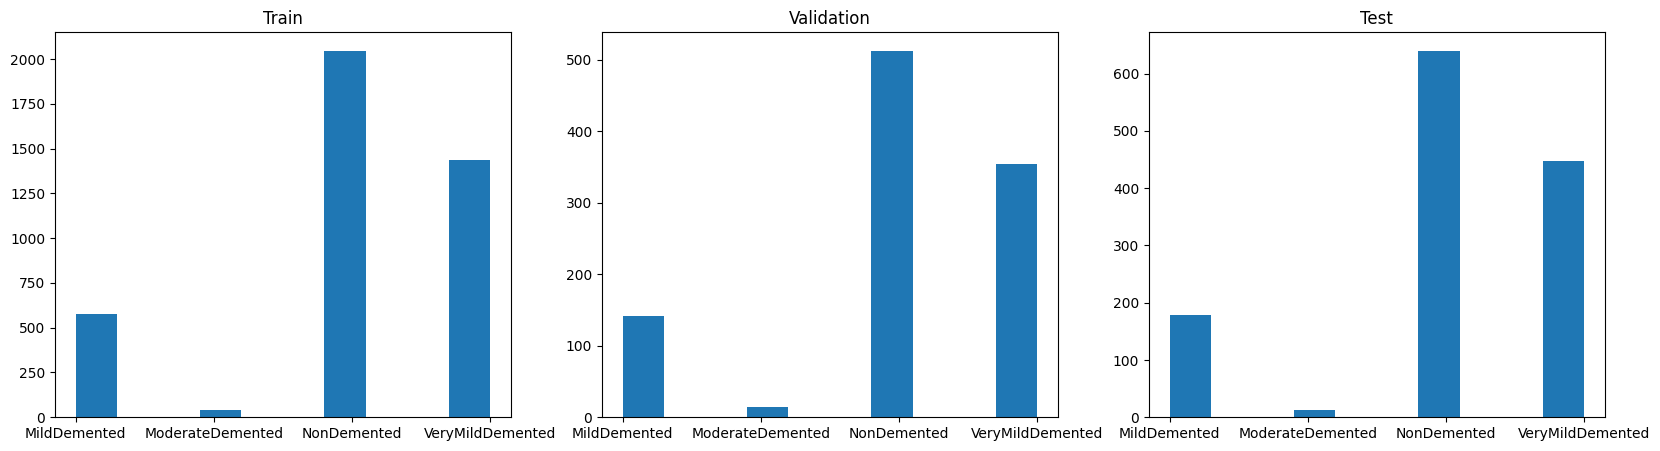

In [13]:
ds = [train_ds, val_ds, test_ds]
ds_string = ['Train', 'Validation', 'Test']
plt.figure(figsize=(20, 5))

for i in range(3):
  ax = plt.subplot(1, 3, i + 1)
  current_ds = ds[i]
  true_categories = tf.concat([y for x, y in current_ds], axis=0).numpy().astype(int)
  true_categories = [class_names[i] for i in sorted(true_categories)]

  for tipe in class_names:
    print(ds_string[i],': ',tipe,' count ',true_categories.count(tipe))
  plt.hist(true_categories)
  plt.title(ds_string[i])

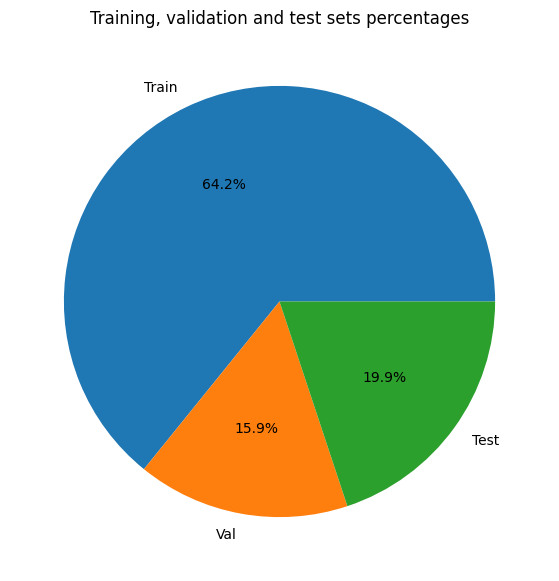

In [14]:
fig = plt.figure(figsize =(10, 7))
plt.pie([len(train_ds), len(val_ds), len(test_ds)], labels = ["Train", "Val", "Test"],  autopct='%1.1f%%')
plt.title("Training, validation and test sets percentages")
# show plot
plt.show()

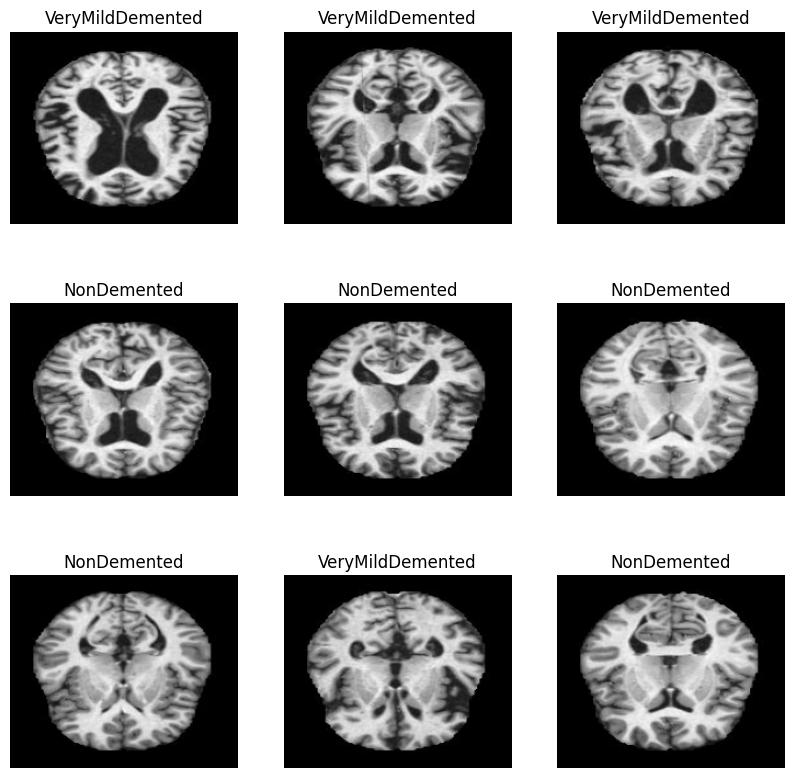

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [16]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


train_ds_prefetch = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
val_ds_prefetch = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
test_ds_prefetch = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)


## Models

In [21]:
def resnet50():
  rn = ResNet50(input_shape=(IMG_SIZE[0],IMG_SIZE[1],3), weights='imagenet', include_top=False)
  for layer in rn.layers:
      layer.trainable = False
  x = layers.Flatten()(rn.output)
  prediction = layers.Dense(4, activation='softmax')(x)

  return Model(inputs=rn.input, outputs=prediction)

In [19]:
EPOCHS = 10

model = resnet50()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer='adam',loss=tf.losses.CategoricalCrossentropy(), metrics=[keras.metrics.AUC(name='auc'),'acc'])
history = model.fit(train_ds_prefetch, epochs=EPOCHS, validation_data=val_ds_prefetch, callbacks=callback)
model.save('resnet_normalized.h5')

model.summary()

129/129 [==============================] - 555s 4s/step - loss: 4.2004 - auc: 0.8015 - acc: 0.5865 - val_loss: 0.5970 - val_auc: 0.9578 - val_acc: 0.8282
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 176, 208, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 182, 214, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 88, 104, 64)          9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 8

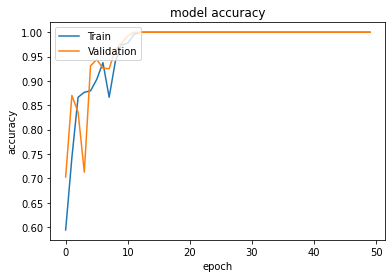

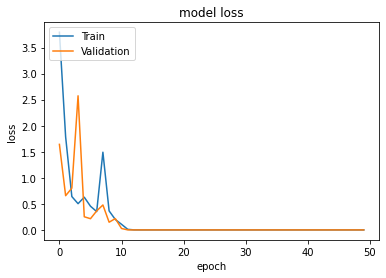

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
#test_scores = model_resnet.evaluate(test_ds_prefetch)
test_acc = model_resnet.evaluate(test_ds_prefetch, verbose=1)

40/40 [==============================] - 5s 100ms/step - loss: 4.0953 - auc: 0.8220 - acc: 0.6669


In [ ]:
y_pred = model_resnet.predict(test_ds_prefetch, verbose=1)

40/40 [==============================] - 4s 76ms/step


In [ ]:
predicted_categories = tf.argmax(y_pred, axis=1).numpy()
predicted_categories

array([3, 2, 3, ..., 2, 3, 3])

In [ ]:
true_categories = tf.concat([y for x, y in test_ds_prefetch], axis=0)
true_categories = tf.argmax(true_categories, axis=1).numpy()
#true_categories_label = true_categories.numpy()
true_categories_label = [class_names[int(y)] for y in true_categories]
print(true_categories)


[3 2 3 ... 0 0 0]


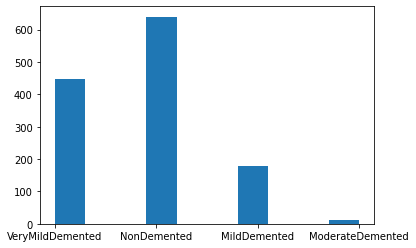

In [ ]:

plt.hist(true_categories_label)
plt.show()

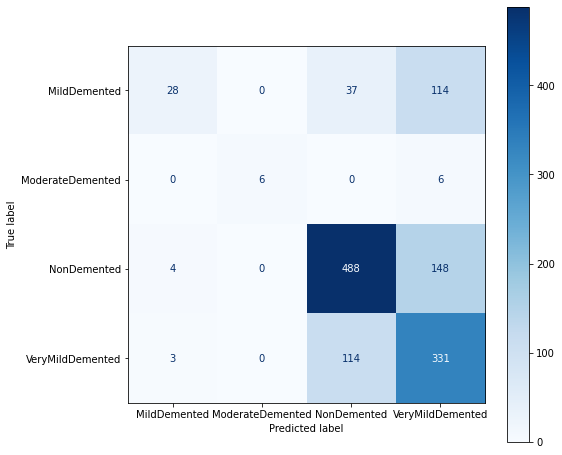

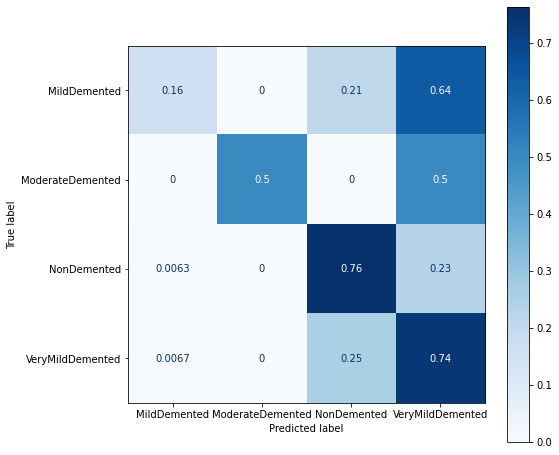

In [ ]:
cm = confusion_matrix(true_categories, predicted_categories)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()


In [ ]:
print(classification_report( true_categories, predicted_categories, target_names=class_names))

                  precision    recall  f1-score   support

    MildDemented       0.80      0.16      0.26       179
ModerateDemented       1.00      0.50      0.67        12
     NonDemented       0.76      0.76      0.76       640
VeryMildDemented       0.55      0.74      0.63       448

        accuracy                           0.67      1279
       macro avg       0.78      0.54      0.58      1279
    weighted avg       0.70      0.67      0.65      1279



In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.6):

    img = tf.reshape(img, shape=[176, 208, 3], name='y')
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
    return superimposed_img


tf.Tensor(3, shape=(), dtype=int32)


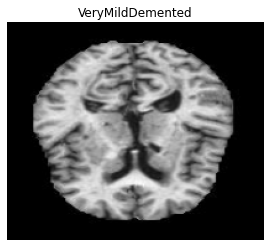

VeryMildDemented


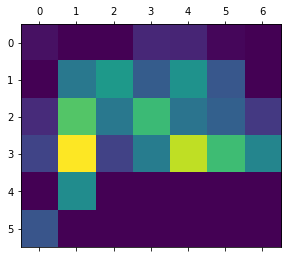

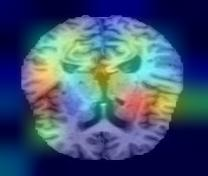

In [ ]:
last_conv_layer = 'conv5_block3_out'
preprocess_input = keras.applications.resnet50.preprocess_input
decode_predictions = keras.applications.resnet50.decode_predictions

for images, labels in train_ds.take(1):
  image, label = images[0], labels[0]
  print(label)
  plt.imshow(image.numpy().astype("uint8"))
  plt.title(train_ds.class_names[label])
  plt.axis("off")
  plt.show()

  model_resnet.layers[-1].activation = None
  image = tf.reshape(image, shape=[-1, 176, 208, 3], name='y')
  preds = model_resnet.predict(image, verbose=0)
  predicted_class = train_ds.class_names[np.argmax(preds[0])]
  print("Predicted class: ", predicted_class)

  heatmap = make_gradcam_heatmap(image, model_resnet, last_conv_layer)
  plt.matshow(heatmap)
  plt.show()
  save_and_display_gradcam(image, heatmap, alpha=0.8)



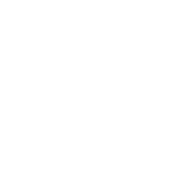

Label:  NonDemented
Predicted:  NonDemented


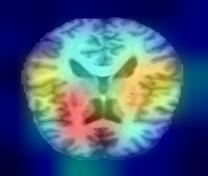

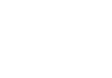

Label:  NonDemented
Predicted:  NonDemented


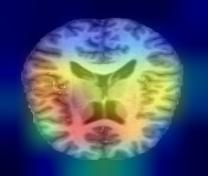

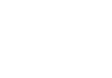

Label:  Demented
Predicted:  Demented


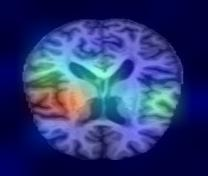

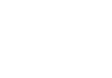

Label:  Demented
Predicted:  Demented


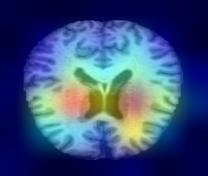

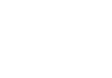

Label:  NonDemented
Predicted:  NonDemented


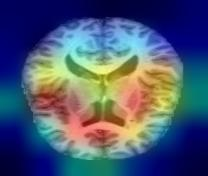

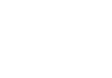

Label:  Demented
Predicted:  Demented


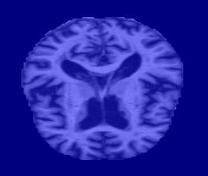

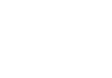

Label:  Demented
Predicted:  Demented


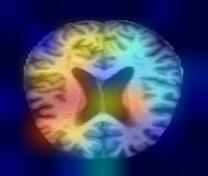

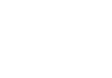

Label:  Demented
Predicted:  Demented


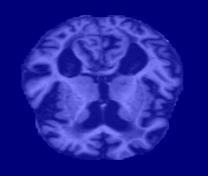

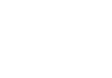

Label:  Demented
Predicted:  Demented


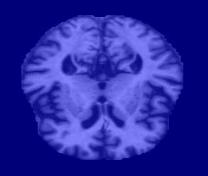

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image, label = images[i], labels[i]
    plt.axis("off")
    plt.show()
    model_resnet.layers[-1].activation = None
    image = tf.reshape(image, shape=[-1, 176, 208, 3], name='y')
    preds = model_resnet.predict(image, verbose=0)
    predicted_class = train_ds.class_names[np.argmax(preds[0])]
    if predicted_class != 'NonDemented':
      predicted_class = 'Demented'
    actual_class = train_ds.class_names[labels[i]]
    if actual_class != 'NonDemented':
      actual_class = 'Demented'
    print("Label: ", actual_class)
    print("Predicted: ", predicted_class)


    heatmap = make_gradcam_heatmap(image, model_resnet, last_conv_layer)
    save_and_display_gradcam(image, heatmap, alpha=0.9)

## Bibliography

 - https://www.kaggle.com/code/vishakansubramanian/alzheimer-s-disease-classification-notebook

 - https://www.kaggle.com/code/amyjang/alzheimer-mri-model-tensorflow-2-3-data-loading

 - https://tree.rocks/get-heatmap-from-cnn-convolution-neural-network-aka-grad-cam-222e08f57a34

 - https://arxiv.org/abs/1610.02391

 - https://keras.io/examples/vision/grad_cam/

 - https://ieeexplore.ieee.org/abstract/document/8784845